In [17]:
'''
Activate conda environment


# Install env from yml
$ conda env create -f test_yolosam_env.yml

# Activate env
$ conda activate yolosam_env


Notes on installation:

$ conda create -n yolosam_env python=3.9 -c conda-forge \
    ultralytics segment-anything ipykernel \
    numpy opencv matplotlib pillow \
    shapely scikit-image pandas scipy

The ellipse package is not available though conda, so use pip instead:

$ micromamba activate env_yolosam
(yolosam_env) 
$ pip install lsq-ellipse


'''

import os
from ultralytics import YOLO
from ultralytics.engine import results as rs
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import json
from PIL import Image
from skimage import measure, draw
from skimage.draw import polygon2mask
from skimage.transform import resize
import math
from shapely.geometry import Polygon
import ellipse
# from ellipse import LsqEllipse
from ultralytics.data.utils import polygon2mask
import pandas as pd
from scipy import spatial

In [22]:
'''
Run this batch of functions first.
'''

'''
Author: Fatima Davelouis
'''

# =================================
def fit_ellipse_v1(cnt_points_arr):
# =================================
    reg = ellipse.LsqEllipse().fit(cnt_points_arr)
    center, width, height, phi = reg.as_parameters()

    # center: ellipse centre
    # width: semimajor axis. Horizontal dimension of the ellipse (**)
    # height: semiminor axis. Vertical dimension of the ellipse (**)
    # phi: radians -- tilt of the ellipse, the angle the semimajor axis makes with the x-axis
   
    # print(f'center: {center[0]:.3f}, {center[1]:.3f}')
    # print(f'width  (semimajor axis): {width:.3f}')
    # print(f'height (semiminor axis): {height:.3f}')
    # print(f'phi angle (radians): {phi:.3f}')

    angle = np.rad2deg(phi)

    return reg, center, width, height, angle

# ==============================
def fit_ellipse_v2(cnt_points):
# ==============================
    cnt_points_arr = np.array(cnt_points)
    cnt_points_arr = cnt_points_arr.reshape(-1, 2, 1)

    X = cnt_points_arr[:,0]
    Y = cnt_points_arr[:,1]
    A = np.hstack([X**2, X * Y, Y**2, X, Y])
    b = np.ones_like(X)
    alphas = np.linalg.lstsq(A, b, rcond=-1)[0].squeeze()
    # print("alphas=", alphas)
    Z = alphas[0] * X ** 2 + alphas[1] * X * Y + alphas[2] * Y**2 + alphas[3] * X + alphas[4] * Y

    return alphas, cnt_points_arr, X, Y, Z

# ===================================================================
def plot_ellipse(cnt_points_arr, alphas=np.array([]), img_show=False):
# ===================================================================
    ellipse_coord = None

    X = cnt_points_arr[:,0]
    Y = cnt_points_arr[:,1]

    X_min = np.min(cnt_points_arr[:, 0])
    X_max = np.max(cnt_points_arr[:, 0])
    Y_min = np.min(cnt_points_arr[:, 1])
    Y_max = np.max(cnt_points_arr[:, 1])

    x_coord = np.linspace(X_min-10, X_max+10, 300)
    y_coord = np.linspace(Y_min-10, Y_max+10, 300)
    # print("type(x_coord): ", type(x_coord), ", x_coord.shape: ", x_coord.shape)

    X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
    # print("type(X_coord): ", type(X_coord), ", X_coord.shape: ", X_coord.shape)

    if len(alphas)>0:
       Z_coord = alphas[0] * X_coord ** 2 + alphas[1] * X_coord * Y_coord + alphas[2] * Y_coord**2 + alphas[3] * X_coord + alphas[4] * Y_coord
       tt = plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
       my_tt = tt.allsegs[0][0]
       my_tt_int_arr = np.array([[int(round(item[0],0)), int(round(item[1],0))] for item in my_tt])
       ellipse_coord = my_tt_int_arr

    #    print("type(tt): ", type(tt))
    #    print("type(tt.allsegs): ", type(tt.allsegs))
    #    print("type(tt.allsegs[0][0]): ", type(tt.allsegs[0][0]))
    #    print("my_tt.shape: ", my_tt.shape)
    #    print("my_tt_int_arr.shape: ", my_tt_int_arr.shape)
    #    print("my_tt_int_arr[10]: ", my_tt_int_arr[10])
       
    # if img_show:
    #    plt.scatter(X, Y, label='Data Points')
    #    if len(alphas)>0:
    #       plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
    #    plt.show()
    #    #plt.close()

    return ellipse_coord

# ==========================================================================
def plot_polygon(mask_binary, contour_points, color=(255,0,0), thickness=1):
# ==========================================================================
    # Polygon corner points coordinates draw
    # ======================================
    polycontour_mask = np.zeros((mask_binary.shape[0], mask_binary.shape[1]), dtype="uint8")
    pts = np.array(contour_points, np.int32)
    pts = pts.reshape((-1, 1, 2))
    # print("contour_points.shape: ", contour_points.shape)
    # print("pts.shape: ", pts.shape)
    #print("pts contour first 10: ", contour_points[:10])
    isClosed = True
    cv2.polylines(polycontour_mask, [pts], isClosed, color, thickness)
    return polycontour_mask

# ===========================================================================
def create_fitting_ellipse(img, mask, cnt_points):
    '''
    Fits ellipse onto muscle mask.
    inputs:
        img: cv2 image object
        mask: muscle mask (binary numpy array)
        cnt_points: muscle mask contour points
    outputs:
        center: central coordinate of ellipse, 
        angle: angle of ellipse inclination (wrt x-axis), 
        img_color_ellipse_overlay: image with ellipse overlayed.
    '''
    # ===========================================================================
    cnt_points_arr = cnt_points[0]    
    # print("type(cnt_points): ", type(cnt_points), "len(cnt_points): ", len(cnt_points), "cnt_points[0].shape: ", cnt_points[0].shape)

    # print("Run fit_ellipse_v2()")
    # ===========================
    alphas, cnt_points_arr, X, Y, Z = fit_ellipse_v2(cnt_points)

    # print("Run plot_ellipse()")
    # =========================
    ellipse_coord = plot_ellipse(cnt_points_arr, alphas=alphas, img_show=False)

    # print("Run fit_ellipse_v1()")
    # =========================
    reg, center, width, height, angle = fit_ellipse_v1(ellipse_coord)

    # print("alphas: ", alphas)
    # print("reg.coefficients: ", reg.coefficients)
    # print("major axis (pixels): ", 2*width)
    # print("minor axis (pixels): ", 2*height)
    # print("angle (degrees): ", angle)

    # print("Run plot_polygon")
    # =======================
    polycontour_ellipse_mask = plot_polygon(mask, ellipse_coord, color=(255,0,0), thickness=5)
    polycontour_ellipse_mask_3c = np.stack([polycontour_ellipse_mask, 
                                            polycontour_ellipse_mask, 
                                            polycontour_ellipse_mask], axis = -1)
    # print("Stack polycontour_ellipse_mask_3c.shape: ", polycontour_ellipse_mask_3c.shape)

    # The original image will be in the background with transparency 0.3
    # The other image will be pasted above the original image with transparency 0.7
    
    img_color_ellipse_overlay = cv2.addWeighted(img, 0.1, polycontour_ellipse_mask_3c, 1, 0)

    # return alphas, center, 2*width, 2*height, reg.coefficients, loin_coord, ellipse_coord, angle, polycontour_ellipse_mask, polycontour_mask, img_color_ellipse_overlay
    return center, angle, img_color_ellipse_overlay

'''
Author: Edward Yakubovitch
'''

def check_mask_presence (current_image):
    '''
    Checks whether there are masks inferred to each class (0 = muscle, 1 = fat).
    YOLOv8 sometimes fails at inferring a mask for either the muscle or fat due to factors associated with the image.
    If such case, this function returns false and the loop skips a sample/image.
    '''
    classes = current_image.boxes.cls.numpy().astype('int')
    confidences = current_image.boxes.conf.numpy()

    combo_list = np.column_stack((classes,confidences))
    
    muscle_present = False
    fat_present = False
    
    for i in combo_list[:,0]:
        if i == 0:
            muscle_present = True
        elif i == 1:
            fat_present = True
            
    if muscle_present == True and fat_present == True:
        return True
    else:
        return False

def mask_selector(current_image):
    
    '''
    YOLOv8 often predicts multiple potential masks for a class. It is *usually* the case that the first mask is the most 'accurate' mask.
    However, this function goes through each binary mask by confidence score and chooses the best one.
    Returns masks and bounding boxes for those masks.
    '''
    
    classes = current_image.boxes.cls.numpy().astype('int')
    confidences = current_image.boxes.conf.numpy()

    combo_list = np.column_stack((classes,confidences))

    confidence_muscle = 0 
    confidence_fat = 0

    j = 0
    for i in combo_list[:,0]:
        if i == 0 and combo_list[:,1][j] > confidence_muscle:
            confidence_muscle = combo_list[:,1][j]
            muscle_bbox = current_image.boxes[j].xyxy
            muscle_mask = current_image.masks[j].xy
        elif i == 1 and combo_list[:,1][j] > confidence_fat:
            confidence_fat = combo_list[:,1][j]
            fat_bbox = current_image.boxes[j].xyxy
            fat_mask = current_image.masks[j].xy
        j += 1

    return muscle_bbox[0], muscle_mask, fat_bbox[0], fat_mask

def return_min_max_mask_coords(contours):
    
    '''
    Function to return the minimum and maximum coordinates in a countour list from any binary mask.
    Used to calculate LD width and height.
    Returns a list of 4 points - horizontal minima and maxima, and vertical minima and maxima.
    '''
    
    min_x = np.argmin(contours[:,0])
    max_x = np.argmax(contours[:,0])
    min_y = np.argmin(contours[:,1])
    max_y = np.argmax(contours[:,1])
    h1_point = contours[min_x,:]
    h2_point = contours[max_x,:]
    v1_point = contours[min_y,:]
    v2_point = contours[max_y,:]
    
    list_points = [h1_point, h2_point, v1_point, v2_point]
    
    return list_points

def rotation_detector(image_aspectratio, muscle_contour, fat_contour):
    
    '''
    Function to detect the rotation of an image by the relationship of the muscle and fat contours to each other.
    Works through simple logic gates, where the aspect ratio of the image first determins if the image is in vertical or horizontal orientation.
    Then, the contours of muscle to fat determine if the fat layer is above the muscle (standard) or below (upside down).
    Occasionally fails as the fat layer can wrap around the muscle by being very long or the muscle being small in diameter.
    An exception means that the prediciton was inaccurate, and elsewhere in the main code this is corrected by simply doing the opposite of what this function predicts.
    '''
    
    img_ar = image_aspectratio
    
    list_muscle = return_min_max_mask_coords(muscle_contour)
    list_fat = return_min_max_mask_coords(fat_contour)
    
    
    if img_ar[0] < img_ar[1]:
        if list_muscle[2][1] > list_fat[2][1]:
            return ("FAT_TOP")
        else:
            return ("FAT_BOTTOM")
    else:
        if list_muscle[0][0] > list_fat[0][0]:
            return ("FAT_LEFT")
        else:
            return ("FAT_RIGHT") 
        
def line_extender(p1, p2):
    
    '''
    Extends a drawn line off the image. Used to calculcate fat depth by later seeing which parts of the line fall within the fat contour.
    '''
    
    # p1 = min_v_muscle.copy()
    # p2 = max_v_muscle.copy()

    theta = np.arctan2(p1[1]-p2[1], p1[0]-p2[0])
    endpt_x = int(p1[0] - 5000*np.cos(theta))
    endpt_y = int(p1[1] - 5000*np.sin(theta))

    # #line_img = np.zeros_like()
    # image_line = cv2.line(image_line.copy(), max_v_muscle, (endpt_x, endpt_y), (0,255,0), 20)
    # image_line = cv2.line(image_line, max_v_muscle, min_v_muscle, (0,0, 255), 20)
    
    return p1, p2, endpt_x, endpt_y

def return_measurements(depth_1, depth_2, width_1, width_2):
    
    '''
    Returns measurements for LD width and depth. Later used to also calculate fat depth by extending LD depth off the image and seeing which point falls into
    the binary mask for the fat layer.
    '''
    
    muscle_depth = abs(math.dist(depth_1, depth_2))
    muscle_width = abs(math.dist(width_1, width_2))
    
    return muscle_depth, muscle_width 

def rotation_detector_by_angle(current_fat_placement, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle):
    
    '''
    A simple logic-gated function to detect the orientation of the fat layer with respect to the muscle layer by way of muscle layer measurements.
    Key input here is the angle of rotation as calculated by a different function (ellipsoid method). Based on this angle we can deduce the likely orientation of the fat layer.
    Once we know orientation and location of the fat layer, we can extend a line from the muscle measurements so as to capture the depth of the fat layer
    by way of its binary mask. Where that line falls within the binary mask of the fat layer is the fat layer depth, in pixels.
    '''
    
    if angle > 0:
        angle_adj = abs(90 - angle) #Get the rotation matrix, its of shape 2x3
    else:
        angle_adj = 90 + angle
    
    if angle_adj < 45 and current_fat_placement == "FAT_BOTTOM":
        p1, p2, endpt_x, endpt_y = line_extender(min_v_muscle, max_v_muscle)
        ld_depth, ld_width = return_measurements(min_v_muscle, max_v_muscle, min_h_muscle, max_h_muscle)
    elif angle_adj > 45 and current_fat_placement == "FAT_BOTTOM":
        p1, p2, endpt_x, endpt_y = line_extender(min_h_muscle, max_h_muscle)
        ld_depth, ld_width = return_measurements(min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle)
    elif angle_adj < 45 and current_fat_placement == "FAT_TOP":
        p1, p2, endpt_x, endpt_y = line_extender(max_v_muscle, min_v_muscle)
        ld_depth, ld_width = return_measurements(max_v_muscle, min_v_muscle, min_h_muscle, max_h_muscle)
    elif angle_adj > 45 and current_fat_placement == "FAT_TOP":
        p1, p2, endpt_x, endpt_y = line_extender(max_h_muscle, min_h_muscle)
        ld_depth, ld_width = return_measurements(max_h_muscle, min_h_muscle, min_v_muscle, max_v_muscle)
    elif angle_adj < 45 and current_fat_placement == "FAT_RIGHT":
        p1, p2, endpt_x, endpt_y = line_extender(min_h_muscle, max_h_muscle)
        ld_depth, ld_width = return_measurements(min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle)
    elif angle_adj > 45 and current_fat_placement == "FAT_RIGHT":
        p1, p2, endpt_x, endpt_y = line_extender(max_v_muscle, min_v_muscle)
        ld_depth, ld_width = return_measurements(max_v_muscle, min_v_muscle, min_h_muscle, max_h_muscle)
    elif angle_adj < 45 and current_fat_placement == "FAT_LEFT":
        p1, p2, endpt_x, endpt_y = line_extender(max_h_muscle, min_h_muscle)
        ld_depth, ld_width = return_measurements(max_h_muscle, min_h_muscle, min_v_muscle, max_v_muscle)
    elif angle_adj > 45 and current_fat_placement == "FAT_LEFT":
        p1, p2, endpt_x, endpt_y = line_extender(min_v_muscle, max_v_muscle)
        ld_depth, ld_width = return_measurements(min_v_muscle, max_v_muscle, min_h_muscle, max_h_muscle)
    
    return p1, p2, endpt_x, endpt_y, ld_depth, ld_width

def drawlines(contour_points, mask):
    
    '''
    A function that takes in min and max contour points in a binary mask and returns actual drawn lines and other calculcaitons, such as the total area.
    '''
    
    min_x = np.argmin(contour_points[:,0])
    max_x = np.argmax(contour_points[:,0])
    min_y = np.argmin(contour_points[:,1])
    max_y = np.argmax(contour_points[:,1])
    h1_point = contour_points[min_x,:]
    h2_point = contour_points[max_x,:]
    v1_point = contour_points[min_y,:]
    v2_point = contour_points[max_y,:]
    
    list_points = [h1_point, h2_point, v1_point, v2_point]
    horizontal_points = [h1_point, h2_point]
    
    myarea = 0
    list_points2 = []
    for i, mypoint in enumerate(contour_points):
        a = mypoint[0]
        b = mypoint[1]
        if i == 0:
            first_point = (a, b)
        mypoint2 = (a,b)
        list_points2.append(mypoint2)
    
    list_points2.append(first_point)
    mypolygon = Polygon(list_points2)
    myarea = mypolygon.area
    
    
    color = (0, 0, 255)
    thickness = 9 
    
    with_line = cv2.line(mask, h1_point.astype('int32'), h2_point.astype('int32'), color, thickness)
    with_line = cv2.line(with_line, v1_point.astype('int32'), v2_point.astype('int32'), color, thickness)
    
    return myarea, h1_point, h2_point, v1_point, v2_point, with_line

def rotate_image(img, bbox, angle, center):
    
    '''
    A function to rotate the image according to a rotation matrix influenced by the angle calculcated during the ellipsoid fitting.
    '''

    #img_path = results[0].orig_img #The image path
    #bbox = results[0].boxes.xyxy.numpy()[0] #XMIN,YMIN,XMAX,YMAX
    #angle = angle #Rotation angle in degrees, +ve is counter-clockwise

    bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3]))) #Get all 4 coordinates of the box

    # img = cv2.imread(img_path) #Read the img
    #img = results[0].orig_img

    #center = (img.shape[0]//2,img.shape[1]//2) #Get the center of the image
    if angle > 0:
        rotMat = cv2.getRotationMatrix2D(center, abs(90 - angle) ,1.0) #Get the rotation matrix, its of shape 2x3
    else:
        rotMat = cv2.getRotationMatrix2D(center, (90 + angle) ,1.0)

    img_rotated = cv2.warpAffine(img,rotMat,img.shape[1::-1]) #Rotate the image

    bb_rotated = np.vstack((bbox.T,np.array((1,1,1,1)))) #Convert the array to [x,y,1] format to dot it with the rotMat
    bb_rotated = np.dot(rotMat,bb_rotated).T #Perform Dot product and get back the points in shape of (4,2)
    
    return img_rotated, bb_rotated, bbox

def bbox_reformatter(bbox):
    
    '''
    Function to reformat a bounding box into a format required by either YOLOv8 or other software.
    Unfortunately, different software stacks 
    '''
    
    min_x = bbox[0,][0]
    min_y = bbox[0,][1]
    max_x = bbox[2,][0]
    max_y = bbox[2,][1]
    
    return np.array([min_x, min_y, max_x, max_y])

def line_to_fat(orientation, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle, rotated_fat_mask):
    
    '''
    Function to find which points of a line extended from the muscle fall onto the fat layer. 
    These points are returned as a calculation of the depth of the fat layer.
    '''
    
    p1, p2, endpt_x, endpt_y, ld_depth, ld_width = rotation_detector_by_angle(orientation, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle)
    #image_line = cv2.line(image_line.copy(), p2, (endpt_x, endpt_y), (0,255,0), 20)
    discrete_line = list(zip(*draw.line(*p2, *np.array([endpt_x, endpt_y]))))
    contours, hierarchy = cv2.findContours(rotated_fat_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pts = measure.points_in_poly(discrete_line, contours[0].reshape(-1, 2))
    disc_line_fat = np.array(discrete_line)[pts]
    max_fat_pt = disc_line_fat[disc_line_fat.shape[0] - 1]
    
    return p1, p2, max_fat_pt, ld_depth, ld_width

def reverse_orientation (orientation): 
    
    '''
    Function to reverse orientation. Usually called in case of an error exception.
    '''
    
    if orientation == "FAT_RIGHT":
        orientation_reverse = "FAT_LEFT"
    elif orientation == "FAT_LEFT":
        orientation_reverse = "FAT_RIGHT"
    elif orientation == "FAT_BOTTOM":
        orientation_reverse = "FAT_TOP"
    elif orientation == "FAT_TOP":
        orientation_reverse = "FAT_BOTTOM"
    
    return orientation_reverse
    
def convert_contours_to_image(contours, orig_shape):
    
    '''
    Helper function to convert YOLO inferred contours into a binary mask, as a ready to display image. Uses API from YOLO itself to accomplish this, not pil or cv2.
    '''
    
    # try original image size?

    #img = cv2.imread(results[0].path)
    #img = current_image.orig_img.copy()
    #img = cv2.resize(img, results[0].orig_shape,interpolation = cv2.INTER_AREA)
    mask = polygon2mask(
        orig_shape,  # tuple
        [contours],  # input as list
        color=255,  # 8-bit binary
        downsample_ratio=1,
    )
    #mask = cv2.resize(mask,img.shape[1::-1],interpolation = cv2.INTER_AREA)
    #cnt_pts = current_image.masks.xy[0].copy()

    

    return mask

def return_measurements(depth_1, depth_2, width_1, width_2):
    
    '''
    Helper function to enumerate the distance between lines so as to calculcate (in pixels) muscle width and depth.
    '''
    
    muscle_depth = abs(math.dist(depth_1, depth_2))
    muscle_width = abs(math.dist(width_1, width_2))
    
    return muscle_depth, muscle_width 

def box_line(muscle_bbox, fat_bbox, img_rect, orientation):
    
    '''
    Helper function to draw a bounding box based on x1y1x2y2 coordinates of a possible box.
    '''
    
    bbox = muscle_bbox
    muscle_bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3])))
    bbox = fat_bbox
    fat_bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3])))
    
    if orientation == "FAT_RIGHT":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[1,]) / 2
        fat_connect = (fat_bbox[1][0], mid_pt_muscle[1])
    elif orientation == "FAT_LEFT":
        mid_pt_muscle = (muscle_bbox[3,] + muscle_bbox[0,]) / 2
        fat_connect = (fat_bbox[3][0], mid_pt_muscle[1])
    elif orientation == "FAT_BOTTOM":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[3,]) / 2
        fat_connect = (mid_pt_muscle[0], fat_bbox[3][1])
    elif orientation == "FAT_TOP":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[3,]) / 2
        fat_connect = (mid_pt_muscle[0], fat_bbox[1][1])
        
    fat_connect = np.array(fat_connect)

    img_rect = cv2.line(img_rect, mid_pt_muscle.astype('int32'), fat_connect.astype('int32'), (0,255,255), 20)
    
    return img_rect

def box_line_with_offset(muscle_bbox, fat_bbox, img_rect, orientation):
    
    '''
    Helper function to draw a box as before, but with a certain offset based on angle adjustments from the ellipsoid method.
    '''
    
    bbox = muscle_bbox
    muscle_bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3])))
    bbox = fat_bbox
    fat_bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3])))
    
    if orientation == "FAT_RIGHT":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[1,]) / 2
        fat_connect = (fat_bbox[1][0], mid_pt_muscle[1] - 400)
    elif orientation == "FAT_LEFT":
        mid_pt_muscle = (muscle_bbox[3,] + muscle_bbox[0,]) / 2
        fat_connect = (fat_bbox[3][0], mid_pt_muscle[1] + 400)
    elif orientation == "FAT_BOTTOM":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[3,]) / 2
        fat_connect = (mid_pt_muscle[0] - 400, fat_bbox[3][1])
    elif orientation == "FAT_TOP":
        mid_pt_muscle = (muscle_bbox[1,] + muscle_bbox[0,]) / 2
        fat_connect = (mid_pt_muscle[0] + 400, fat_bbox[1][1])
        
    fat_connect = np.array(fat_connect)
    
    return mid_pt_muscle, fat_connect

def line_to_fat_box_method(mid_pt_muscle, fat_connect, fat_mask):
    
    '''
    Method to connect a line from the fat to the bounding box of the fat.
    '''
    
    discrete_line = list(zip(*draw.line(*mid_pt_muscle, *fat_connect)))
    contours, hierarchy = cv2.findContours(fat_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pts = measure.points_in_poly(discrete_line, contours[0].reshape(-1, 2))
    disc_line_fat = np.array(discrete_line)[pts]
    max_fat_pt = disc_line_fat[disc_line_fat.shape[0] - 1]
    
    return max_fat_pt

def convert_back_to_xyxy(bbox):
    
    '''
    Helper function to convert a mask to YOLO xyxy format.
    '''
    
    bbox = np.array((bbox[0][0], bbox[0][1], bbox[2][0], bbox[2][1]))
    
    return bbox

def rotate_box_line(mid_pt_muscle, fat_connect, angle, center):
    
    '''
    Helper function to rotate a line (created as a pseudobox) according to an angle derived from the ellipsoid method.
    '''
    
    bbox = np.concatenate([mid_pt_muscle, fat_connect])

    #img_path = results[0].orig_img #The image path
    #bbox = results[0].boxes.xyxy.numpy()[0] #XMIN,YMIN,XMAX,YMAX
    #angle = angle #Rotation angle in degrees, +ve is counter-clockwise

    bbox = np.array(((bbox[0],bbox[1]),(bbox[2],bbox[1]),(bbox[2],bbox[3]),(bbox[0],bbox[3]))) #Get all 4 coordinates of the box

    # img = cv2.imread(img_path) #Read the img
    #img = results[0].orig_img

    #center = (img.shape[0]//2,img.shape[1]//2) #Get the center of the image

    rotMat = cv2.getRotationMatrix2D(center, abs(90 - angle) ,1.0) #Get the rotation matrix, its of shape 2x3

    bb_rotated = np.vstack((bbox.T,np.array((1,1,1,1)))) #Convert the array to [x,y,1] format to dot it with the rotMat
    bb_rotated = np.dot(rotMat,bb_rotated).T #Perform Dot product and get back the points in shape of (4,2)
    
    mid_pt_muscle = convert_back_to_xyxy(bb_rotated)[0:2]
    fat_connect = convert_back_to_xyxy(bb_rotated)[2:4]
    
    return mid_pt_muscle, fat_connect

def calculcate_midpoint_muscle_box(muscle_bbox, fat_bbox, orientation):
    
    '''
    Helper function to calculcate the midpoint of the muscle bounding box.
    Reminder: all bounding boxes are derived from YOLO inference results.
    '''
    
    muscle_bbox = np.array(((muscle_bbox[0],muscle_bbox[1]),(muscle_bbox[2],muscle_bbox[1]),(muscle_bbox[2],muscle_bbox[3]),(muscle_bbox[0],muscle_bbox[3])))
    fat_bbox = np.array(((fat_bbox[0],fat_bbox[1]),(fat_bbox[2],fat_bbox[1]),(fat_bbox[2],fat_bbox[3]),(fat_bbox[0],fat_bbox[3])))
    
    if orientation == "FAT_TOP":
        mid_pt_muscle = (muscle_bbox[1,] + muscle_bbox[0,]) / 2
        fat_connect = (mid_pt_muscle[0], fat_bbox[0][1])
    elif orientation == "FAT_BOTTOM":
        mid_pt_muscle = (muscle_bbox[3,] + muscle_bbox[2,]) / 2
        fat_connect = (mid_pt_muscle[0], fat_bbox[3][1])
    elif orientation == "FAT_RIGHT":
        mid_pt_muscle = (muscle_bbox[2,] + muscle_bbox[1,]) / 2
        fat_connect = (fat_bbox[1][0], mid_pt_muscle[1])
    elif orientation == "FAT_LEFT":
        mid_pt_muscle = (muscle_bbox[0,] + muscle_bbox[3,]) / 2
        fat_connect = (fat_bbox[0][0], mid_pt_muscle[1])
        
    
    fat_connect = np.array(fat_connect)
    
    
    return mid_pt_muscle, fat_connect

def draw_rotated_boxes_lines(img, muscle_bbox, fat_bbox, mid_pt_muscle, fat_connect):
    
    '''
    Helper function to draw rotated bounding boxes and lines that criss cross them.
    '''
    
    pt1_muscle = muscle_bbox[0:2].numpy()
    pt2_muscle = muscle_bbox[2:4].numpy()

    pt1_fat = fat_bbox[0:2].numpy()
    pt2_fat = fat_bbox[2:4].numpy()
    
    img_rect = cv2.rectangle(img.copy(), pt1_muscle.astype('int32'), pt2_muscle.astype('int32'), (255,0,0), 20)
    img_rect = cv2.rectangle(img_rect, pt1_fat.astype('int32'), pt2_fat.astype('int32'), (0,0,255), 20)
    
    img_rect = cv2.line(img_rect, mid_pt_muscle.astype('int32'), fat_connect.astype('int32'), (0,255,255), 20)

    plt.imshow(img_rect)
    plt.show()
    
def find_nearest_contour_point(contour, p2):
    
    '''
    Helper function to locate the contour point that is closest to another point. Used in the push-pull method to identify where the muscle depth line should meet the fat depth line.
    '''
    
    distances = np.linalg.norm(contour-p2, axis=1)
    min_index = np.argmin(distances)
    # print(f"the closest point is {contour[min_index]}, at a distance of {distances[min_index]}")
    
    return contour[min_index]

def line_to_fat_corrector(new_p1, endpt_x, endpt_y, rotated_fat_mask):
    
    '''
    Modified function to help correct the distance between muscle and fat bsaed on the push-pull method.
    '''
    
    discrete_line = list(zip(*draw.line(*new_p1.astype('int32'), *np.array([endpt_x, endpt_y]))))
    contours, _ = cv2.findContours(rotated_fat_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    pts = measure.points_in_poly(discrete_line, contours[0].reshape(-1, 2))
    disc_line_fat = np.array(discrete_line)[pts]
    max_fat_pt = disc_line_fat[disc_line_fat.shape[0] - 1]
    
    return max_fat_pt

def rotation_detector_by_angle_corrector(current_fat_placement, angle, fat_bbox, muscle_bbox, p2):
    
    print ("old p2:", p2)
    
    max = 6.5
    min = 5.5
    common_distance = 6.0
    
    if angle > 0:
        angle_adj = abs(90 - angle) #Get the rotation matrix, its of shape 2x3
    else:
        angle_adj = 90 + angle
    
    if angle_adj < 45 and current_fat_placement == "FAT_BOTTOM":
        print ("angle < 45")
        
        fat_pt = (fat_bbox[1] + fat_bbox[2]) / 2
        muscle_pt1 = (muscle_bbox[0] + muscle_bbox[1]) / 2
        muscle_pt2 = (muscle_bbox[2] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt1
        
        if (abs(p2 - fat_pt)[0] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[0] / 140) > common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] - 1
        elif (abs(p2 - fat_pt)[0] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[0] / 140) < common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] - 1
        else:
            print ("Within 6 +/- 0.5 ")
            
    
    elif angle_adj > 45 and current_fat_placement == "FAT_BOTTOM":
        print ("angle > 45")
        
        fat_pt = (fat_bbox[1] + fat_bbox[2]) / 2
        muscle_pt1 = (muscle_bbox[0] + muscle_bbox[1]) / 2
        muscle_pt2 = (muscle_bbox[2] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt1
        
        if (abs(p2 - fat_pt)[1] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[1] / 140) > common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] - 1
        elif (abs(p2 - fat_pt)[1] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[1] / 140) < common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] + 1
        else:
            print ("Within 6 +/- 0.5 ")
            
    elif angle_adj < 45 and current_fat_placement == "FAT_TOP":
        print ("angle < 45")
        
        fat_pt = (fat_bbox[0] + fat_bbox[3]) / 2
        muscle_pt1 = (muscle_bbox[0] + muscle_bbox[1]) / 2
        muscle_pt2 = (muscle_bbox[2] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt2
        
        if (abs(p2 - fat_pt)[0] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[0] / 140) > common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] + 1
        elif (abs(p2 - fat_pt)[0] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[0] / 140) < common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] + 1
        else:
            print ("Within 6 +/- 0.5 ")
            
    elif angle_adj > 45 and current_fat_placement == "FAT_TOP":
        print ("angle > 45")
        
        fat_pt = (fat_bbox[0] + fat_bbox[3]) / 2
        muscle_pt1 = (muscle_bbox[0] + muscle_bbox[1]) / 2
        muscle_pt2 = (muscle_bbox[2] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt2
        
        if (abs(p2 - fat_pt)[1] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[1] / 140) > common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] + 1
        elif (abs(p2 - fat_pt)[1] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[1] / 140) < common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] - 1
        else:
            print ("Within 6 +/- 0.5 ")
    elif angle_adj < 45 and current_fat_placement == "FAT_RIGHT":
        print ("angle < 45")
        
        fat_pt = (fat_bbox[0] + fat_bbox[1]) / 2
        muscle_pt1 = (muscle_bbox[1] + muscle_bbox[2]) / 2
        muscle_pt2 = (muscle_bbox[0] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt2
        
        if (abs(p2 - fat_pt)[0] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[1] / 140) > common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] - 1
        elif (abs(p2 - fat_pt)[0] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[1] / 140) < common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] + 1
        else:
            print ("Within 6 +/- 0.5 ")
            
    elif angle_adj > 45 and current_fat_placement == "FAT_RIGHT":
        
        print ("angle > 45")
        
        fat_pt = (fat_bbox[0] + fat_bbox[1]) / 2
        muscle_pt1 = (muscle_bbox[1] + muscle_bbox[2]) / 2
        muscle_pt2 = (muscle_bbox[0] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt2
        
        if (abs(p2 - fat_pt)[0] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[0] / 140) > common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] + 1
        elif (abs(p2 - fat_pt)[0] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[0] / 140) < common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] + 1
        else:
            print ("Within 6 +/- 0.5 ")
    
    elif angle_adj < 45 and current_fat_placement == "FAT_LEFT":
        print ("angle < 45")
        
        fat_pt = (fat_bbox[2] + fat_bbox[3]) / 2
        muscle_pt1 = (muscle_bbox[1] + muscle_bbox[2]) / 2
        muscle_pt2 = (muscle_bbox[0] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt1
        
        if (abs(p2 - fat_pt)[1] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[1] / 140) > common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] + 1
        elif (abs(p2 - fat_pt)[1] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[1] / 140) < common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] - 1
        else:
            print ("Within 6 +/- 0.5 ")
            
    elif angle_adj > 45 and current_fat_placement == "FAT_LEFT":
        print ("angle > 45")
        
        fat_pt = (fat_bbox[2] + fat_bbox[3]) / 2
        muscle_pt1 = (muscle_bbox[1] + muscle_bbox[2]) / 2
        muscle_pt2 = (muscle_bbox[0] + muscle_bbox[3]) / 2
        muscle_mid = muscle_pt1
        
        if (abs(p2 - fat_pt)[0] / 140 > max):
            print ("More than 6.5")
            while (abs(p2 - fat_pt)[0] / 140) > common_distance:
                p2[0] = p2[0] + 1
                p2[1] = p2[1] - 1
        elif (abs(p2 - fat_pt)[0] / 140 < min):
            print ("Less than 5.5")
            while (abs(p2 - fat_pt)[0] / 140) < common_distance:
                p2[0] = p2[0] - 1
                p2[1] = p2[1] - 1
        else:
            print ("Within 6 +/- 0.5 ")
    
    print ("new p2:", p2)
    
    return p2, muscle_mid, fat_pt

def correct_measurements(image_line, orientation, rotated_fat_box, rotated_muscle_box, rotated_fat_mask, p2, muscle_bbox, fat_bbox, angle, center):
    mid_pt_muscle_boxes, fat_connect_boxes = calculcate_midpoint_muscle_box(muscle_bbox, fat_bbox, orientation)
    mid_pt_muscle, fat_connect = rotate_box_line(mid_pt_muscle_boxes, fat_connect_boxes, angle, center)
    
    new_p2, new_p1 = distance_corrector(image_line.copy(), orientation, rotated_fat_box, rotated_muscle_box, rotated_fat_mask.copy(), p2, angle, center)
    new_p1, new_p2, end_x_method2, end_y_method2 = line_extender(new_p1, new_p2)
    new_p1, mid_pt_muscle, end_x_method1, end_y_method1 = line_extender(new_p1, mid_pt_muscle)
    
    max_fat_pt_method2 = line_to_fat_corrector(new_p1, end_x_method2, end_y_method2, rotated_fat_mask.copy())
    max_fat_pt_method1 = line_to_fat_corrector(new_p1, end_x_method1, end_y_method1, rotated_fat_mask.copy())
    
    
    # image_line = cv2.line(image_line, new_p1.astype('int32'), np.array((end_x_method1, end_y_method1)).astype('int32'), (0,255,255), 10)
    image_line = cv2.line(image_line, new_p1.astype('int32'),  mid_pt_muscle.astype('int32'), (0,255,255), 10)
    image_line = cv2.line(image_line, mid_pt_muscle.astype('int32'), max_fat_pt_method1, (255,255,0), 10)
    # image_line = cv2.line(image_line, new_p1.astype('int32'), np.array((end_x_method2, end_y_method2)).astype('int32'), (255,0,255), 10)
    image_line = cv2.line(image_line, new_p1.astype('int32'), new_p2.astype('int32'), (255,0,255), 10)
    image_line = cv2.line(image_line, new_p2.astype('int32'), max_fat_pt_method2, (255,255,0), 10)
    
    # plt.imshow(image_line)
    # plt.show()
    
    return image_line

def distance_corrector(img, orientation, rotated_fat_box, rotated_muscle_box, rotated_muscle_mask, point_where_muscle_connects_to_fat, angle, center):
    fat_bbox = rotated_fat_box
    muscle_bbox = rotated_muscle_box
    p2 = point_where_muscle_connects_to_fat
    rotated_contours, _ = cv2.findContours(rotated_muscle_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rotated_contours = rotated_contours[0].reshape(-1,2)
    
    print (orientation)
    
    if orientation == "FAT_TOP":
        # img_line = cv2.line(img.copy(), fat_bbox[0].astype('int32'), fat_bbox[3].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[0].astype('int32'), muscle_bbox[1].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[2].astype('int32'), muscle_bbox[3].astype('int32'), (0,255,255), 10)
        

        new_p2, muscle_mid, fat_pt = rotation_detector_by_angle_corrector("FAT_TOP", angle, fat_bbox, muscle_bbox, p2)
            
        new_p2 = find_nearest_contour_point(rotated_contours, new_p2)
        
        
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), new_p2.astype('int32'), (255, 0, 0), 10)
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), muscle_mid.astype('int32'), (255, 0, 0), 10)
        
        # plt.imshow(img_line)
        # plt.show()
        
                
        
    elif orientation == "FAT_BOTTOM":
        # img_line = cv2.line(img.copy(), fat_bbox[1].astype('int32'), fat_bbox[2].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[0].astype('int32'), muscle_bbox[1].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[2].astype('int32'), muscle_bbox[3].astype('int32'), (0,255,255), 10)
        
        new_p2, muscle_mid, fat_pt = rotation_detector_by_angle_corrector("FAT_BOTTOM", angle, fat_bbox, muscle_bbox, p2)
            
        new_p2 = find_nearest_contour_point(rotated_contours, new_p2)
        
        
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), new_p2.astype('int32'), (255, 0, 0), 10)
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), muscle_mid.astype('int32'), (255, 0, 0), 10)
        
        # plt.imshow(img_line)
        # plt.show()
    elif orientation == "FAT_RIGHT":
        # img_line = cv2.line(img.copy(), fat_bbox[0].astype('int32'), fat_bbox[1].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[1].astype('int32'), muscle_bbox[2].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[0].astype('int32'), muscle_bbox[3].astype('int32'), (0,255,255), 10)
        

        new_p2, muscle_mid, fat_pt = rotation_detector_by_angle_corrector("FAT_RIGHT", angle, fat_bbox, muscle_bbox, p2)
            
        new_p2 = find_nearest_contour_point(rotated_contours, new_p2)
        
        
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), new_p2.astype('int32'), (255, 0, 0), 10)
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), muscle_mid.astype('int32'), (255, 0, 0), 10)
        
        # plt.imshow(img_line)
        # plt.show()
            
    elif orientation == "FAT_LEFT":
        # img_line = cv2.line(img.copy(), fat_bbox[2].astype('int32'), fat_bbox[3].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[1].astype('int32'), muscle_bbox[2].astype('int32'), (0,255,255), 10)
        # img_line = cv2.line(img_line, muscle_bbox[0].astype('int32'), muscle_bbox[3].astype('int32'), (0,255,255), 10)
        

        new_p2, muscle_mid, fat_pt = rotation_detector_by_angle_corrector("FAT_LEFT", angle, fat_bbox, muscle_bbox, p2)
            
        new_p2 = find_nearest_contour_point(rotated_contours, new_p2)
        
        
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), new_p2.astype('int32'), (255, 0, 0), 10)
        # img_line = cv2.line(img_line, fat_pt.astype('int32'), muscle_mid.astype('int32'), (255, 0, 0), 10)
        
        # plt.imshow(img_line)
        # plt.show()
            
    
    # img_line = cv2.line(img_line, fat_pt.astype('int32'), p2.astype('int32'), (255, 255, 0), 10)

    
    # img_line = cv2.line(img_line, fat_pt.astype('int32'), new_p2.astype('int32'), (255, 255, 0), 10)
    

    
    return new_p2, muscle_mid

In [23]:
'''
Run the inference second.
'''

model_path = 'last.pt' 

# model trained using YOLOv8 based on training images derived from SAM.
# pt (PyTorch Tensors): This format is optimized for the PyTorch framework. 
# It stores the model architecture and learned parameters as tensors, 
# a data structure that PyTorch heavily relies on for efficient machine learning computations.

image_path = 'raw_images/' # raw images

model = YOLO(model_path)

results = model(image_path, save = True, project = "output/segment")


image 1/4 /home/maaz/work/porkvision/raw_images/1701_LdLeanColor.JPG: 448x640 1 ['muscle'], 1 ['fat'], 4190.1ms
image 2/4 /home/maaz/work/porkvision/raw_images/1704_LdLeanColor.JPG: 640x448 1 ['muscle'], 1 ['fat'], 6852.8ms
image 3/4 /home/maaz/work/porkvision/raw_images/2401_LdLeanColor.JPG: 640x448 1 ['muscle'], 1 ['fat'], 4691.3ms
image 4/4 /home/maaz/work/porkvision/raw_images/724_LDLeanColour.JPG: 448x640 1 ['muscle'], 1 ['fat'], 4238.5ms
Speed: 4.6ms preprocess, 4993.2ms inference, 5.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict


In [20]:
len(results)
# os.getcwd()

4

/home/maaz/work/porkvision/raw_images/1701_LdLeanColor.JPG
FAT_TOP
1483.513734348287
Orientation required reversion:  False 
 First fat mask was a bad mask:  False
FAT_TOP
old p2: [2244 1234]
angle < 45
More than 6.5
new p2: [2054 1424]
/home/maaz/work/porkvision/raw_images/1704_LdLeanColor.JPG
FAT_RIGHT
1388.2251258351432
Orientation required reversion:  False 
 First fat mask was a bad mask:  False
FAT_RIGHT
old p2: [1676 1613]
angle > 45
Less than 5.5
new p2: [2006 1943]
/home/maaz/work/porkvision/raw_images/2401_LdLeanColor.JPG
FAT_LEFT
1591.0153990455276
Orientation required reversion:  False 
 First fat mask was a bad mask:  False
FAT_LEFT
old p2: [1639 3444]
angle > 45
More than 6.5
new p2: [1764 3319]
/home/maaz/work/porkvision/raw_images/724_LDLeanColour.JPG
FAT_TOP
1330.3089866643763
Orientation required reversion:  True 
 First fat mask was a bad mask:  False
Reverted
FAT_TOP FAT_BOTTOM
FAT_BOTTOM
old p2: [2286 2368]
angle < 45
More than 6.5
new p2: [3060 1594]


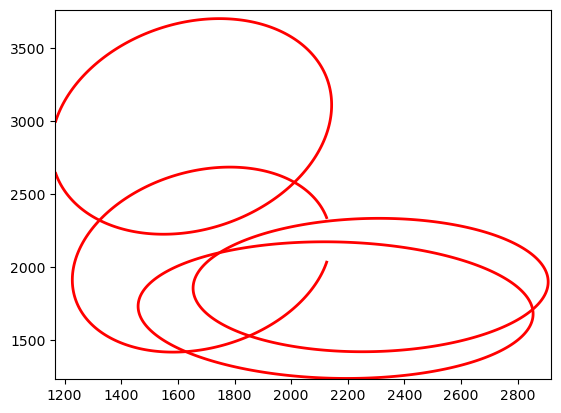

In [24]:
'''
Run the main script third.
'''

id_list = []
ld_depth_list = []
ld_width_list = []
muscle_to_fat_list = []

# for i in range(0, 4):
for i in range(0, len(results)):
    result = results[i]
    print (result.path)
    
    if check_mask_presence(result) == False:
        print ("Model failed to create a mask for either fat or muscle for image ", result.path, ". Please calculate dimensions manually.")
        id_list.append(result.path.split("/")[-1].split("_")[0])
        ld_depth_list.append(None)
        ld_width_list.append(None)
        muscle_to_fat_list.append(None)
        continue
    
    reversion = False
    bad_mask = False
    
    orig_shape = result.orig_shape
    muscle_bbox, muscle_cnt, fat_bbox, fat_cnt = mask_selector(result)
    
    muscle_mask = convert_contours_to_image(muscle_cnt[0], orig_shape)
    fat_mask = convert_contours_to_image(fat_cnt[0], orig_shape)
    
    orig_image = result.orig_img
    
    # plt.imshow(orig_image.copy())
    # plt.show()
    
    center, angle, img_ellipse = create_fitting_ellipse(orig_image.copy(), muscle_mask, muscle_cnt)
    
    msc_contour, _ = cv2.findContours(muscle_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    fat_contour, _ = cv2.findContours(fat_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #orientation = rotation_detector(orig_shape, muscle_cnt[0], fat_cnt[0])
    orientation = rotation_detector(orig_shape, msc_contour[0].reshape(-1,2), fat_contour[0].reshape(-1,2))
    print (orientation)

    
    img_rotated, _, bbox = rotate_image(orig_image.copy(), 
                                        bbox = muscle_bbox,
                                        angle = angle,
                                        center = center)

    _, rotated_muscle_box, _ = rotate_image(orig_image.copy(), 
                                        bbox = muscle_bbox,
                                        angle = angle,
                                        center = center)

    _, rotated_fat_box, _ = rotate_image(orig_image.copy(), 
                                        bbox = fat_bbox,
                                        angle = angle,
                                        center = center)

    rotated_muscle_mask, _, _ = rotate_image(muscle_mask.copy(), 
                                        bbox = muscle_bbox,
                                        angle = angle,
                                        center = center)
    
    rotated_fat_mask, _, _ = rotate_image(fat_mask.copy(), 
                                        bbox = fat_bbox,
                                        angle = angle,
                                        center = center)
    

    
    # img_rotated = cv2.line(img_rotated, rotated_muscle_box[0].astype('int32'), rotated_muscle_box[1].astype('int32'), (255,0,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_muscle_box[1].astype('int32'), rotated_muscle_box[2].astype('int32'), (255,0,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_muscle_box[2].astype('int32'), rotated_muscle_box[3].astype('int32'), (255,0,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_muscle_box[3].astype('int32'), rotated_muscle_box[0].astype('int32'), (255,0,0), 20)
    
    # img_rotated = cv2.line(img_rotated, rotated_fat_box[0].astype('int32'), rotated_fat_box[1].astype('int32'), (0,255,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_fat_box[1].astype('int32'), rotated_fat_box[2].astype('int32'), (0,255,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_fat_box[2].astype('int32'), rotated_fat_box[3].astype('int32'), (0,255,0), 20)
    # img_rotated = cv2.line(img_rotated, rotated_fat_box[3].astype('int32'), rotated_fat_box[0].astype('int32'), (0,255,0), 20)
    
    contours, hierarchy = cv2.findContours(rotated_muscle_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    area_muscle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle, image_line = drawlines (contours[0].reshape(-1,2), img_rotated.copy())
    
    # plt.imshow(rotated_muscle_mask)
    # plt.show()
    # plt.imshow(rotated_fat_mask)
    # plt.show()
    # plt.imshow(orig_image)
    # plt.show()
    
    
    try:
        p1, p2, max_fat_pt, ld_depth, ld_width = line_to_fat(orientation, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle, rotated_fat_mask.copy())
        # mid_pt_muscle_boxes, fat_connect_boxes = calculcate_midpoint_muscle_box(muscle_bbox, fat_bbox, orientation)
        # mid_pt_muscle, fat_connect = rotate_box_line(mid_pt_muscle_boxes, fat_connect_boxes, angle, center)
    except:
        orientation_reverse = reverse_orientation(orientation)
        reversion = True
        # print ("The orientation was wrong, attempting to fix!")
        try:    
            p1, p2, max_fat_pt, ld_depth, ld_width = line_to_fat(orientation_reverse, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle, rotated_fat_mask.copy())
            # mid_pt_muscle_boxes, fat_connect_boxes = calculcate_midpoint_muscle_box(muscle_bbox, fat_bbox, orientation_reverse)
            # mid_pt_muscle, fat_connect = rotate_box_line(mid_pt_muscle_boxes, fat_connect_boxes, angle, center)
        except:
            current_mask = 2
            bad_mask = True
            while True:
                try:
                    # print ("Probably bad mask, doing next mask!")
                    new_fat_contour = result.masks.xy[current_mask]
                    new_fat_bbox = result.boxes.xyxy[current_mask]
                    new_fat_mask = convert_contours_to_image(new_fat_contour, orig_shape)
                    new_rotated_fat_mask, new_rotated_fat_box, _ = rotate_image(new_fat_mask.copy(), 
                        bbox = new_fat_bbox,
                        angle = angle,
                        center = center)
                    p1, p2, max_fat_pt, ld_depth, ld_width = line_to_fat(orientation_reverse, angle, min_h_muscle, max_h_muscle, min_v_muscle, max_v_muscle, new_rotated_fat_mask.copy())
                    # mid_pt_muscle_boxes, fat_connect_boxes = calculcate_midpoint_muscle_box(muscle_bbox, fat_bbox, orientation_reverse)
                    # mid_pt_muscle, fat_connect = rotate_box_line(mid_pt_muscle_boxes, fat_connect_boxes, angle, center)
                    break
                except:
                    current_mask += 1
                    # print (current_mask)
                if current_mask >= len(result.boxes.cls):
                    break

            # plt.imshow(new_rotated_fat_mask)
            # plt.show()
            
    print(ld_width)
    
    image_old = cv2.line(image_line.copy(), p2, max_fat_pt, (255,255,0), 10)
    image_old = cv2.line(image_old, p1, p2, (0,0, 255), 20)
    
    
    # plt.imshow(image_line)
    # plt.show()
    
    muscle_to_fat = abs(math.dist(p2, max_fat_pt))
    
    # conversion factor should be about 136-140 pixels for 10 mm
    # print ("LD_depth (pixels): ", ld_depth, " LD_width (pixels): ", ld_width, "Fat_depth (pixels): ", muscle_to_fat)
    ld_depth_list.append(ld_depth)
    ld_width_list.append(ld_width)
    muscle_to_fat_list.append(muscle_to_fat)
    id_list.append(result.path.split("/")[-1].split("_")[0])

    
    #cv2.imwrite(('runs/annotated_images/' + result.path.split("/")[-1].split(".")[0] + "_annotated.JPG"), image_line)
    
    
    # plt.imshow(image_line)
    # plt.show()
    
    

    # draw_rotated_boxes_lines(orig_image.copy(), muscle_bbox, fat_bbox, mid_pt_muscle_boxes, fat_connect_boxes)
    # mid_pt_muscle, fat_connect = rotate_box_line(mid_pt_muscle_boxes, fat_connect_boxes, angle, center)
    # draw_rotated_boxes_lines(img_rotated.copy(), muscle_bbox, fat_bbox, mid_pt_muscle_boxes, fat_connect_boxes)
    
    
    
    # new_p2, new_p1 = distance_corrector(image_line.copy(), orientation, rotated_fat_box, rotated_muscle_box, rotated_fat_mask.copy(), p2)
    # new_p1, new_p2, end_x_method2, end_y_method2 = line_extender(new_p1, new_p2)
    # new_p1, mid_pt_muscle, end_x_method1, end_y_method1 = line_extender(new_p1, mid_pt_muscle)
    
    # max_fat_pt_method2 = line_to_fat_corrector(new_p1, end_x_method2, end_y_method2, rotated_fat_mask.copy())
    # max_fat_pt_method1 = line_to_fat_corrector(new_p1, end_x_method1, end_y_method1, rotated_fat_mask.copy())
    
    
    # image_line = cv2.line(image_line, new_p1.astype('int32'), np.array((end_x_method1, end_y_method1)).astype('int32'), (0,255,255), 10)
    # image_line = cv2.line(image_line, mid_pt_muscle.astype('int32'), max_fat_pt_method1, (255,255,0), 10)
    # image_line = cv2.line(image_line, new_p1.astype('int32'), np.array((end_x_method2, end_y_method2)).astype('int32'), (255,0,255), 10)
    # image_line = cv2.line(image_line, new_p2.astype('int32'), max_fat_pt_method2, (255,255,0), 10)
    
    # correct_measurements(image_line.copy(), orientation, rotated_fat_box, rotated_muscle_box, rotated_fat_mask.copy(), p2, mid_pt_muscle)
    
    print ("Orientation required reversion: ", reversion, "\n", "First fat mask was a bad mask: ", bad_mask)
    
    try:
        if reversion == True and bad_mask == False:
            print ("Reverted")
            print (orientation, orientation_reverse)
            img_final = correct_measurements(image_old.copy(), orientation_reverse, rotated_fat_box, rotated_muscle_box, rotated_fat_mask.copy(), p2, muscle_bbox, fat_bbox, angle, center)
        elif reversion == True and bad_mask == True:
            print ("Reverted and new mask")
            print (orientation, orientation_reverse)
            #new_muscle_cnt, _ = cv2.findContours(rotated_muscle_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            #new_center, new_angle, new_img_ellipse = create_fitting_ellipse(img_rotated.copy(), rotated_muscle_mask, new_muscle_cnt)
            img_final = correct_measurements(image_old.copy(), orientation_reverse, rotated_fat_box, rotated_muscle_box, new_rotated_fat_mask.copy(), p2, muscle_bbox, fat_bbox, angle, center)
        else:
            img_final = correct_measurements(image_old.copy(), orientation, rotated_fat_box, rotated_muscle_box, rotated_fat_mask.copy(), p2, muscle_bbox, fat_bbox, angle, center)
    except:
        print ("Error in creating measurements, likely bad mask or bad call for orientation of fat relative to muscle")
        
    cv2.imwrite(('output/' + result.path.split("/")[-1].split(".")[0] + "_annotated.JPG"), img_final) 



In [12]:
'''
Make table of results - WIP
'''
# ADD VARIABLES THAT CAN GO HERE FOR MEASUREMENTS

#list_of_measurements = list(zip(id_list, ld_depth_list, ld_width_list, muscle_to_fat_list, muscle_to_fat_box_method_list))
#df = pd.DataFrame(list_of_measurements, columns=['image_id', 'ld_depth_px', 'ld_width_px', 'fat_depth_px', 'fat_depth_box_px'])

list_of_measurements = list(zip(id_list, ld_depth_list, ld_width_list, muscle_to_fat_list))
df = pd.DataFrame(list_of_measurements, columns=['image_id', 'ld_depth_px', 'ld_width_px', 'fat_depth_px'])


df = pd.concat([df, df.iloc[:,1:5] / 140], axis = 1)

#df = df.rename(columns = {df.columns[5]: "ld_depth_mm", df.columns[6]: "ld_width_mm", df.columns[7]: "fat_depth_mm", df.columns[8]: "fat_depth_box_mm"})

df = df.rename(columns = {df.columns[5]: "ld_depth_mm", df.columns[6]: "ld_width_mm"})


df.to_csv("output/results.csv", index=False)


In [ ]:
# FOR DEBUGGING PURPOSES - NOT REQUIRED

# AK: required to run only for the previous method 
muscle_to_fat_box_method_list = []

# for i in range(3):
for i in range(len(results)):
    result = results[i]
    print (i)
    
    if check_mask_presence(result) == False:
        print ("Model failed to create a box for either fat or muscle for image ", result.path, ". Please calculate dimensions manually.")
        muscle_to_fat_box_method_list.append(None)
        continue
    
    
    orig_shape = result.orig_shape
    muscle_bbox, muscle_cnt, fat_bbox, fat_cnt = mask_selector(result)
    
    muscle_mask = convert_contours_to_image(muscle_cnt[0], orig_shape)
    fat_mask = convert_contours_to_image(fat_cnt[0], orig_shape)
    
    orig_image = result.orig_img
    
    center, angle, img_ellipse = create_fitting_ellipse(orig_image.copy(), muscle_mask, muscle_cnt)
    
    msc_contour, _ = cv2.findContours(muscle_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    fat_contour, _ = cv2.findContours(fat_mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #orientation = rotation_detector(orig_shape, muscle_cnt[0], fat_cnt[0])
    orientation = rotation_detector(orig_shape, msc_contour[0].reshape(-1,2), fat_contour[0].reshape(-1,2))
    
    pt1_muscle = muscle_bbox.numpy()[0:2]
    pt2_muscle = muscle_bbox.numpy()[2:4]

    pt1_fat = fat_bbox.numpy()[0:2]
    pt2_fat = fat_bbox.numpy()[2:4]

    img_rect = cv2.rectangle(orig_image.copy(), pt1_muscle.astype('int32'), pt2_muscle.astype('int32'), (255,0,0), 20)
    img_rect = cv2.rectangle(img_rect, pt1_fat.astype('int32'), pt2_fat.astype('int32'), (0,0,255), 20)
    
    
    mid_pt_muscle, fat_connect = box_line_with_offset(muscle_bbox, fat_bbox, img_rect, orientation)
    
    try:
        max_fat_pt = line_to_fat_box_method(mid_pt_muscle.astype('int32'), fat_connect.astype('int32'), fat_mask.copy())
    except:
        orientation_reverse = reverse_orientation(orientation)
        mid_pt_muscle, fat_connect = box_line_with_offset(muscle_bbox, fat_bbox, img_rect, orientation_reverse)
        try:
            max_fat_pt = line_to_fat_box_method(mid_pt_muscle.astype('int32'), fat_connect.astype('int32'), fat_mask.copy())
        except:
            current_mask = 2
            while True:
                try:
                    new_fat_contour = result.masks.xy[current_mask]
                    new_fat_bbox = result.boxes.xyxy[current_mask]
                    new_fat_mask = convert_contours_to_image(new_fat_contour, orig_shape)
                    mid_pt_muscle, fat_connect = box_line_with_offset(muscle_bbox, new_fat_bbox, img_rect, orientation_reverse)
                    max_fat_pt = line_to_fat_box_method(mid_pt_muscle.astype('int32'), fat_connect.astype('int32'), new_fat_mask.copy())
                    print ("Probably bad mask, doing next mask! ", current_mask)
                    break
                except:
                    current_mask += 1
                if current_mask >= len(result.boxes.cls):
                    break
    
    img_rect = cv2.line(img_rect, mid_pt_muscle.astype('int32'), max_fat_pt, (0,255,255), 20)
    
    muscle_to_fat = abs(math.dist(mid_pt_muscle, max_fat_pt))
    
    muscle_to_fat_box_method_list.append(muscle_to_fat)
    
    cv2.imwrite(('output/annotated_fat_method2/' + result.path.split("/")[-1].split(".")[0] + "_annotated_fat_method_2.JPG"), img_rect)

    # plt.imshow(img_rect)
    # plt.show()

In [ ]:
# FOR DEBUGGING PURPOSES - NOT REQUIRED

result = results[1]

orig_shape = result.orig_shape

plt.imshow(result.orig_img.copy())
plt.show()

for i in range(0, len(result.masks.xy)):
    new_fat_mask = convert_contours_to_image(result.masks.xy[i], orig_shape)
    plt.imshow(new_fat_mask)
    plt.show()


In [ ]:
# FOR DEBUGGING PURPOSES - NOT REQUIRED

result = results[0]
print ((result.path.split("/")[-1].split(".")[0] + "_annotated.JPG"))

result = results[0]
print (result.path)

if check_mask_presence(result) == False:
    print ("Model failed to create a mask for either fat or muscle for image ", result.path, ". Please calculate dimensions manually.")
    id_list.append(result.path.split("/")[-1].split("_")[0])
    ld_depth_list.append(None)
    ld_width_list.append(None)
    muscle_to_fat_list.append(None)

reversion = False
bad_mask = False

orig_shape = result.orig_shape
muscle_bbox, muscle_cnt, fat_bbox, fat_cnt = mask_selector(result)

muscle_mask = convert_contours_to_image(muscle_cnt[0], orig_shape)
fat_mask = convert_contours_to_image(fat_cnt[0], orig_shape)

orig_image = result.orig_img

In [ ]:
plt.imshow(muscle_mask)
plt.show()

In [ ]:
# cv2.imwrite("img1_fat.png", fat_mask)